In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/kvasir_dataset.zip .

In [3]:
!unzip -qq kvasir_dataset.zip

In [4]:
imagePaths = "kvasir_dataset/train/"
test_path = "kvasir_dataset/test/"

In [5]:
batch_size=32
img_height = 224
img_width = 224

In [6]:
import tensorflow as tf

In [7]:
!rm -rf kvasir_dataset/train/.ipynb_checkpoints

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 15300 files belonging to 6 classes.
Using 13005 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 15300 files belonging to 6 classes.
Using 2295 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 2700 files belonging to 6 classes.


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

tf.keras.utils.set_random_seed(1234)

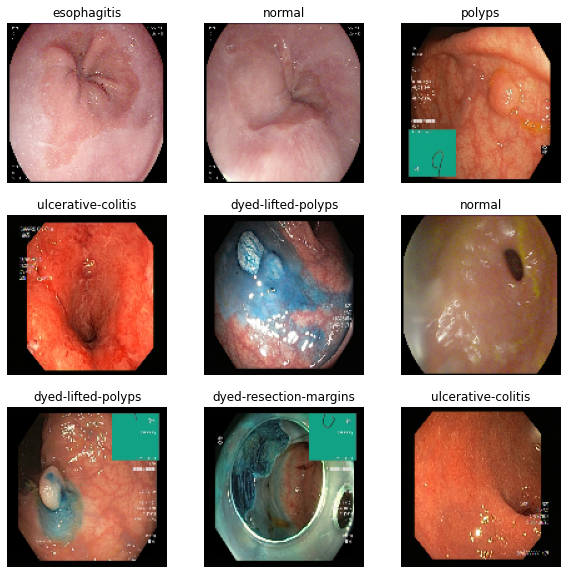

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
data_augmentation= Sequential([
                               layers.RandomBrightness(factor=0.2, value_range=(0, 255), seed=123)
])

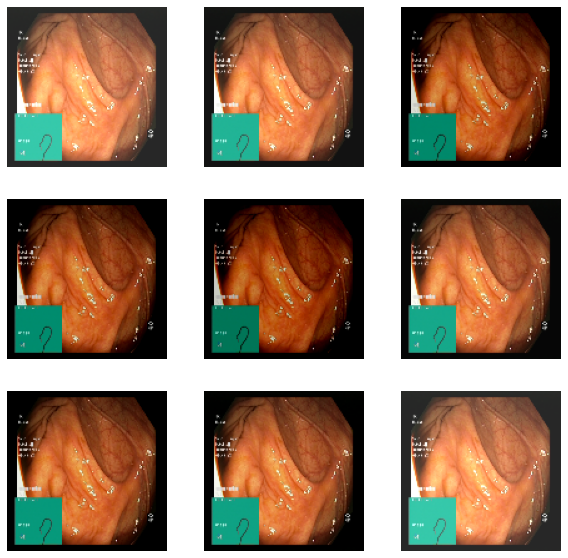

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=128, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = Dropout(0.3)(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = Dropout(0.3)(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = Dropout(0.3)(x)


x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=16, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=16, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = layers.Dense(units=16, activation = "relu")(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

In [13]:
def get_early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
def get_checkpoint_best_only():
    
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [early_stopping, checkpoint_best_only, tensorboard_callback]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, 
                    batch_size=batch_size, epochs=50, callbacks=callbacks)

In [14]:
resnet_base= tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

94765736/94765736 [==============================] - 5s 0us/step


In [15]:
resnet_base.trainable = True

In [ ]:
for layer in resnet_base.layers[: -4]:
  layer.trainable=False

In [16]:
inputs= keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = resnet_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(units=6, activation='softmax')(x)
model= keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                             

In [18]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'],
)

In [19]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=50, callbacks=callbacks)

Epoch 1/50


407/407 [==============================] - ETA: 0s - loss: 3.9022 - accuracy: 0.6239
Epoch 1: val_accuracy improved from -inf to 0.17734, saving model to checkpoints_best_only


407/407 [==============================] - 313s 721ms/step - loss: 3.9022 - accuracy: 0.6239 - val_loss: 34.2658 - val_accuracy: 0.1773
Epoch 2/50
407/407 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.7156
Epoch 2: val_accuracy improved from 0.17734 to 0.72985, saving model to checkpoints_best_only


407/407 [==============================] - 296s 718ms/step - loss: 1.0777 - accuracy: 0.7156 - val_loss: 0.8297 - val_accuracy: 0.7298
Epoch 3/50
407/407 [==============================] - ETA: 0s - loss: 1.0976 - accuracy: 0.7333
Epoch 3: val_accuracy improved from 0.72985 to 0.73464, saving model to checkpoints_best_only


407/407 [==============================] - 297s 720ms/step - loss: 1.0976 - accuracy: 0.7333 - val_loss: 2.8804 - val_accuracy: 0.7346
Epoch 4/50
407/407 [==============================] - ETA: 0s - loss: 0.8784 - accuracy: 0.7852
Epoch 4: val_accuracy improved from 0.73464 to 0.76296, saving model to checkpoints_best_only


407/407 [==============================] - 299s 725ms/step - loss: 0.8784 - accuracy: 0.7852 - val_loss: 0.5458 - val_accuracy: 0.7630
Epoch 5/50
407/407 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.7773
Epoch 5: val_accuracy improved from 0.76296 to 0.83007, saving model to checkpoints_best_only


407/407 [==============================] - 299s 726ms/step - loss: 0.6856 - accuracy: 0.7773 - val_loss: 0.5834 - val_accuracy: 0.8301
Epoch 6/50
407/407 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.8189
Epoch 6: val_accuracy did not improve from 0.83007
407/407 [==============================] - 274s 664ms/step - loss: 0.5323 - accuracy: 0.8189 - val_loss: 0.4517 - val_accuracy: 0.8257
Epoch 7/50
407/407 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.8577
Epoch 7: val_accuracy improved from 0.83007 to 0.86928, saving model to checkpoints_best_only


407/407 [==============================] - 299s 726ms/step - loss: 0.4089 - accuracy: 0.8577 - val_loss: 0.4644 - val_accuracy: 0.8693
Epoch 8/50
407/407 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.8750
Epoch 8: val_accuracy did not improve from 0.86928
407/407 [==============================] - 274s 664ms/step - loss: 0.3481 - accuracy: 0.8750 - val_loss: 0.4079 - val_accuracy: 0.8553
Epoch 9/50
407/407 [==============================] - ETA: 0s - loss: 0.3037 - accuracy: 0.8907
Epoch 9: val_accuracy improved from 0.86928 to 0.87190, saving model to checkpoints_best_only


407/407 [==============================] - 299s 727ms/step - loss: 0.3037 - accuracy: 0.8907 - val_loss: 0.5103 - val_accuracy: 0.8719
Epoch 10/50
407/407 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8927
Epoch 10: val_accuracy did not improve from 0.87190
407/407 [==============================] - 273s 662ms/step - loss: 0.3580 - accuracy: 0.8927 - val_loss: 33.6538 - val_accuracy: 0.6636
Epoch 11/50
407/407 [==============================] - ETA: 0s - loss: 0.6795 - accuracy: 0.8584
Epoch 11: val_accuracy did not improve from 0.87190
407/407 [==============================] - 274s 664ms/step - loss: 0.6795 - accuracy: 0.8584 - val_loss: 0.4999 - val_accuracy: 0.8418
Epoch 12/50
407/407 [==============================] - ETA: 0s - loss: 0.7469 - accuracy: 0.8537
Epoch 12: val_accuracy did not improve from 0.87190
407/407 [==============================] - 273s 661ms/step - loss: 0.7469 - accuracy: 0.8537 - val_loss: 1.7385 - val_accuracy: 0.8383
Epoch 13/50


In [20]:
model.load_weights('./checkpoints_best_only')

In [21]:
model.evaluate(test_ds)

85/85 [==============================] - 39s 415ms/step - loss: 0.6063 - accuracy: 0.8744


[0.6062975525856018, 0.8744444251060486]

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
     

predictions = np.array([])
labels =  np.array([])
cnt=1
for x, y in test_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])
     

print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

1/1 [==============================] - 1s 918ms/step
Confusion Matrix
[[372  77   0   0   1   0]
 [ 33 417   0   0   0   0]
 [  0   1 415  34   0   0]
 [  0   0  53 380   4  13]
 [ 28   0   4  13 357  48]
 [  1   4   3   9  13 420]]


In [23]:
classes=['dyed-lifted-polyps','dyed-resection-margins', 'esophagitis','normal','polyps', 'ulcerative-colitis']
  
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.86      0.83      0.84       450
dyed-resection-margins       0.84      0.93      0.88       450
           esophagitis       0.87      0.92      0.90       450
                normal       0.87      0.84      0.86       450
                polyps       0.95      0.79      0.87       450
    ulcerative-colitis       0.87      0.93      0.90       450

              accuracy                           0.87      2700
             macro avg       0.88      0.87      0.87      2700
          weighted avg       0.88      0.87      0.87      2700



In [24]:
!zip -r resnet50_kvasir_chck.zip checkpoints_best_only

  adding: checkpoints_best_only/ (stored 0%)
  adding: checkpoints_best_only/variables/ (stored 0%)
  adding: checkpoints_best_only/variables/variables.index (deflated 80%)
  adding: checkpoints_best_only/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: checkpoints_best_only/saved_model.pb (deflated 91%)
  adding: checkpoints_best_only/assets/ (stored 0%)
  adding: checkpoints_best_only/keras_metadata.pb (deflated 96%)
